Confrimed by Omar

In [1]:
!nvidia-smi  # this should display information about available GPUs

Thu Apr 17 09:56:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = 'ahmedalhisan'
os.environ['KAGGLE_KEY'] = '159de2c1f4bed2ec0f5a2fd3e803d115'

!kaggle datasets download -d ealaxi/paysim1
!unzip paysim1.zip


Dataset URL: https://www.kaggle.com/datasets/ealaxi/paysim1
License(s): CC-BY-SA-4.0
Archive:  paysim1.zip
  inflating: PS_20174392719_1491204439457_log.csv  Y



In [3]:
%load_ext cudf.pandas

In [4]:

import cudf

df = cudf.read_csv('/content/PS_20174392719_1491204439457_log.csv')

df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
len(df)

6362620

In [6]:
print('Number of Transactions:',df.shape[0])


Number of Transactions: 6362620


In [7]:
df.duplicated().sum()


np.int64(0)

In [8]:
df.isnull().sum()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
df['isFraud'].value_counts()


isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [10]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.291000e-03,3.590500e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,3.000000e-06,1.586000e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [11]:
print(df['type'].nunique())


5


In [12]:
df = cudf.get_dummies(df, columns=['type'])

In [13]:
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,False,False,False,True,False
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,False,False,False,True,False
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,False,False,False,False,True
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,False,True,False,False,False
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,False,False,False,True,False


In [14]:
# Drop 'nameOrig' and 'nameDest' columns
df = df.drop(columns=['nameOrig', 'nameDest'])


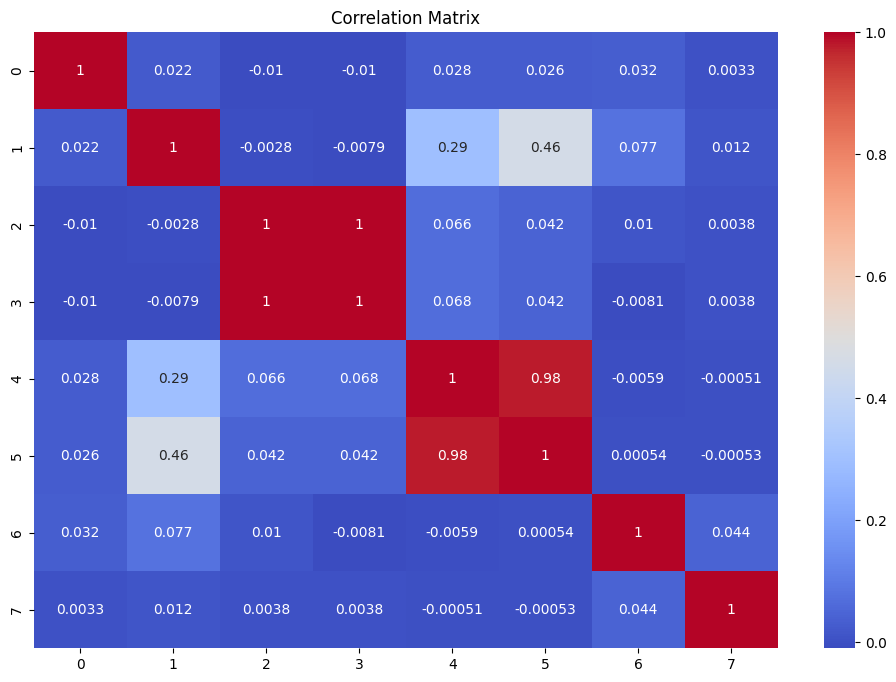

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Use only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# 2. Move to CPU memory (convert to pandas)
numeric_df_cpu = numeric_df.to_pandas()

# 3. Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df_cpu.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


/usr/local/lib/python3.11/dist-packages/cudf/core/indexed_frame.py:3628: UserWarning: GPU-accelerated mergesort is currently not supported, defaulting to quicksort.
  warnings.warn(


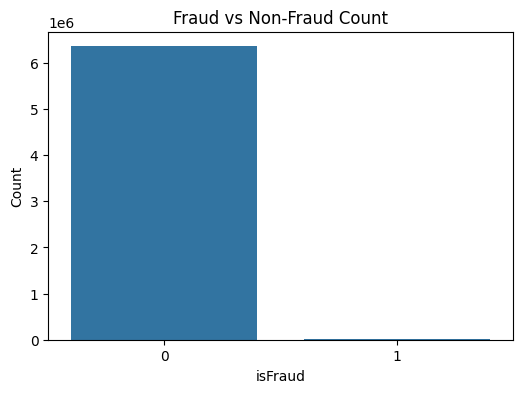

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to pandas for seaborn plotting
df_cpu = df.to_pandas()

plt.figure(figsize=(6, 4))
sns.countplot(data=df_cpu, x='isFraud')
plt.title('Fraud vs Non-Fraud Count')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.show()


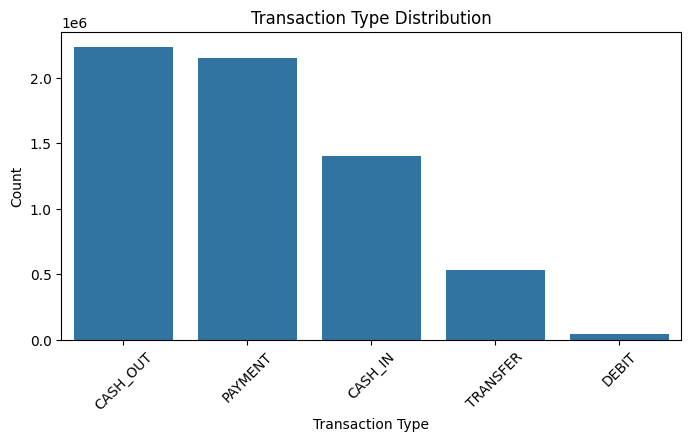

In [17]:
plt.figure(figsize=(8, 4))
# Get the names of the dummy columns related to 'type'
type_columns = [col for col in df_cpu.columns if col.startswith('type_')]

# Plot the countplot using the dummy columns
sns.countplot(data=df_cpu, x=df_cpu[type_columns].idxmax(axis=1).str.replace('type_', ''),
              order=df_cpu[type_columns].idxmax(axis=1).str.replace('type_', '').value_counts().index)

plt.title('Transaction Type Distribution')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [18]:
import cudf
from google.colab import files

# 1. Take all fraud cases
fraud_cases = df[df['isFraud'] == 1]

# 2. Decide how many non-fraud cases to sample for training
needed_nonfraud_train = 1_000_000 - len(fraud_cases)

# 3. Sample non-fraud for training
nonfraud_train = df[df['isFraud'] == 0].sample(
    n=needed_nonfraud_train,
    random_state=101
)

# 4. Build training set
df_train = cudf.concat([fraud_cases, nonfraud_train])

# 5. Create a mask to exclude training rows from the full dataset
train_ids = fraud_cases.index.append(nonfraud_train.index)

# 6. Build remaining dataset (not used in training)
df_remaining = df.drop(index=train_ids)

# 7. Sample 50,000 rows from remaining for testing
df_test = df_remaining.sample(n=50_000, random_state=99)

# 8. Shuffle both training and test sets
df_train = df_train.sample(frac=1, random_state=42)
df_test = df_test.sample(frac=1, random_state=42)

# 9. Show class balance
print("✅ Train class balance:")
print(df_train['isFraud'].value_counts())
print("\n✅ Test class balance:")
print(df_test['isFraud'].value_counts())

# 10. Save the test set as CSV
df_test.to_csv('fraud_test_sample_50k.csv', index=False)
print("\n📁 'fraud_test_sample_50k.csv' saved.")

# 11. (Optional) Trigger download if in Google Colab
try:
    files.download('fraud_test_sample_50k.csv')
except:
    print("⚠️ Download skipped (not in Colab or browser environment).")


✅ Train class balance:
isFraud
0    991787
1      8213
Name: count, dtype: int64

✅ Test class balance:
isFraud
0    50000
Name: count, dtype: int64

📁 'fraud_test_sample_50k.csv' saved.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
target_column = 'isFraud'

X = df_train.drop(columns=[target_column])

y = df_train[target_column]


In [20]:
from cuml.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_scaled.head()


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.479648,-0.246562,-0.289828,-0.291314,-0.324922,-0.335088,-0.004,-0.529237,-0.736973,-0.08146,1.405585,-0.307869
1,0.716823,0.795786,-0.289781,-0.049411,-0.102186,-0.322771,-0.004,1.889513,-0.736973,-0.08146,-0.711448,-0.307869
2,-0.287684,-0.290608,-0.198442,-0.200662,-0.324922,-0.335088,-0.004,-0.529237,-0.736973,-0.08146,1.405585,-0.307869
3,0.033200,-0.260775,-0.250967,-0.259377,-0.324922,-0.335088,-0.004,-0.529237,-0.736973,-0.08146,1.405585,-0.307869
4,0.416866,-0.237281,-0.289967,-0.291314,-0.262818,-0.268227,-0.004,-0.529237,1.356902,-0.08146,-0.711448,-0.307869


In [21]:
from cuml.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=101
)



In [22]:
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (800000, 12)
Test set shape: (200000, 12)


In [23]:
from cuml.svm import SVC

svm_model = SVC(kernel='rbf',class_weight = 'balanced')

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)


In [24]:
# Import from sklearn, NOT from cuml
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print("Accuracy:", accuracy_score(y_test.to_pandas(), y_pred.to_pandas()))
print("Precision:", precision_score(y_test.to_pandas(), y_pred.to_pandas()))
print("Recall:", recall_score(y_test.to_pandas(), y_pred.to_pandas()))
print("F1 Score:", f1_score(y_test.to_pandas(), y_pred.to_pandas()))



Accuracy: 0.968605
Precision: 0.19535908737360644
Recall: 0.954401519949335
F1 Score: 0.32433014096631874


In [25]:
from sklearn.metrics import confusion_matrix

# Convert GPU Series to pandas (CPU)
y_true = y_test.to_pandas()
y_pred_cpu = y_pred.to_pandas()

# Get confusion matrix
cm = confusion_matrix(y_true, y_pred_cpu)

# Unpack values
tn, fp, fn, tp = cm.ravel()

# Print values in confusion matrix format
print("Confusion Matrix:")
print(f"              Predicted 0    Predicted 1")
print(f"Actual 0     |    {tn:>5}         {fp:>5}")
print(f"Actual 1     |    {fn:>5}         {tp:>5}")


Confusion Matrix:
              Predicted 0    Predicted 1
Actual 0     |    192214          6207
Actual 1     |       72          1507


In [26]:
from cuml.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=16,
    random_state=42
)

# 2. Train the model
rf_model.fit(X_train, y_train)

# 3. Predict on test data
y_pred_rf = rf_model.predict(X_test)




/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("Random Forest Metrics:")
print("Accuracy:", accuracy_score(y_test.to_pandas(), y_pred_rf.to_pandas()))
print("Precision:", precision_score(y_test.to_pandas(), y_pred_rf.to_pandas()))
print("Recall:", recall_score(y_test.to_pandas(), y_pred_rf.to_pandas()))
print("F1 Score:", f1_score(y_test.to_pandas(), y_pred_rf.to_pandas()))


Random Forest Metrics:
Accuracy: 0.99789
Precision: 0.9898391193903472
Recall: 0.74034198860038
F1 Score: 0.8471014492753624


In [28]:
from sklearn.metrics import confusion_matrix

# 1. Convert predictions and labels from cuDF to pandas
y_true_rf = y_test.to_pandas()
y_pred_rf_cpu = y_pred_rf.to_pandas()

# 2. Generate confusion matrix
cm_rf = confusion_matrix(y_true_rf, y_pred_rf_cpu)

# 3. Unpack values
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()

# 4. Print nicely
print("🎯 Confusion Matrix: Random Forest")
print(f"              Predicted 0    Predicted 1")
print(f"Actual 0     |    {tn_rf:>5}         {fp_rf:>5}")
print(f"Actual 1     |    {fn_rf:>5}         {tp_rf:>5}")


🎯 Confusion Matrix: Random Forest
              Predicted 0    Predicted 1
Actual 0     |    198409            12
Actual 1     |      410          1169


**XGBoost is the best model detect all frud .**

In [29]:
import xgboost as xgb

# 1. Create the DMatrix (XGBoost's optimized data format)
dtrain = xgb.DMatrix(X_train.to_pandas(), label=y_train.to_pandas())
dtest = xgb.DMatrix(X_test.to_pandas(), label=y_test.to_pandas())

# 2. Set parameters
params = {
    'objective': 'binary:logistic',   # Binary classification (fraud vs non-fraud)
    'tree_method': 'gpu_hist',         # Important: use GPU for training
    'predictor': 'gpu_predictor',      # Use GPU for prediction
    'scale_pos_weight': 6354407/8213,  # Very important for imbalanced dataset
    'eval_metric': 'auc',              # AUC is a good metric for fraud
    'random_state': 101
}

# 3. Train the model
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtest, 'test')],
    early_stopping_rounds=10,
    verbose_eval=10
)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	test-auc:0.97393
[10]	test-auc:0.99920
[20]	test-auc:0.99953
[29]	test-auc:0.99952


In [30]:
# Predict labels
y_pred_xgb = xgb_model.predict(dtest)
y_pred_xgb_binary = (y_pred_xgb > 0.5).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("XGBoost Metrics:")
print("Accuracy:", accuracy_score(y_test.to_pandas(), y_pred_xgb_binary))
print("Precision:", precision_score(y_test.to_pandas(), y_pred_xgb_binary))
print("Recall:", recall_score(y_test.to_pandas(), y_pred_xgb_binary))
print("F1 Score:", f1_score(y_test.to_pandas(), y_pred_xgb_binary))
print("ROC AUC:", roc_auc_score(y_test.to_pandas(), y_pred_xgb))


XGBoost Metrics:
Accuracy: 0.99326
Precision: 0.539568345323741
Recall: 0.9974667511082964
F1 Score: 0.7003112494441974
ROC AUC: 0.9995236409821596


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [31]:
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. Predict probabilities (already done during evaluation)
y_pred_proba_xgb = xgb_model.predict(dtest)

# 2. Convert to binary predictions (0 or 1) using threshold = 0.5
y_pred_xgb = (y_pred_proba_xgb > 0.5).astype(int)

# 3. Get true labels (already in y_test)
y_true_xgb = y_test.to_pandas()

# 4. Confusion matrix
cm_xgb = confusion_matrix(y_true_xgb, y_pred_xgb)

# 5. Unpack values
tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()

# 6. Print neatly
print("🚀 Confusion Matrix: XGBoost")
print(f"              Predicted 0    Predicted 1")
print(f"Actual 0     |    {tn_xgb:>5}         {fp_xgb:>5}")
print(f"Actual 1     |    {fn_xgb:>5}         {tp_xgb:>5}")


🚀 Confusion Matrix: XGBoost
              Predicted 0    Predicted 1
Actual 0     |    197077          1344
Actual 1     |        4          1575


In [ ]:
#classification | SVM | RANDOMFOREST | XGBoost Classifier (GPU)

In [33]:
import joblib

# Save the trained model
joblib.dump(xgb_model, 'xgb_model.joblib')

# Save the scaler
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [35]:

import joblib

# Load the saved model
loaded_model = joblib.load('/content/xgb_model.joblib')

# Print all attributes of the loaded model
for attr in dir(loaded_model):
    if not attr.startswith("__"):  # Exclude special attributes
        print(attr) # Indented this line to be inside the 'if' block

_assign_dmatrix_features
_configure_constraints
_get_feature_info
_set_feature_info
_transform_interaction_constraints
_transform_monotone_constrains
_validate_features
attr
attributes
best_iteration
best_score
boost
copy
dump_model
eval
eval_set
feature_names
feature_types
get_dump
get_fscore
get_score
get_split_value_histogram
handle
inplace_predict
load_config
load_model
num_boosted_rounds
num_features
predict
save_config
save_model
save_raw
set_attr
set_param
trees_to_dataframe
update


In [39]:

import joblib

# Load the model
loaded_model = joblib.load('xgb_model.joblib')


# Load the scaler
loaded_scaler = joblib.load('scaler.joblib')




In [50]:
import pandas as pd
import joblib
import cudf
from cuml.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb  # Import xgboost

# 1. Load the test dataset
df_test = pd.read_csv('/content/fraud_test_sample_50k.csv')

# 2. Separate X and y
X_test = df_test.drop(columns=['isFraud'])  # remove target column
y_test = df_test['isFraud']                # keep it for evaluation

# 3. Convert X_test to cuDF
X_test_cudf = cudf.DataFrame.from_pandas(X_test)

# 4. Load the saved model and scaler
loaded_model = joblib.load('xgb_model.joblib')
loaded_scaler = joblib.load('scaler.joblib')

# 5. Scale the test data
X_test_scaled = loaded_scaler.transform(X_test_cudf)

# 6. Convert the scaled data to DMatrix
# Convert the cuDF DataFrame to pandas before creating DMatrix
X_test_scaled_pandas = X_test_scaled.to_pandas()
dtest = xgb.DMatrix(X_test_scaled_pandas)

# 7. Predict
y_pred = loaded_model.predict(dtest) # Predict using the DMatrix

# 8. Evaluate
accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int)) # Convert predictions to binary
print(f"✅ Model Accuracy: {accuracy:.4f}")

# 9. Optional: Confusion Matrix
cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
tn, fp, fn, tp = cm.ravel()

print("\n📦 Confusion Matrix:")
print(f"              Predicted 0    Predicted 1")
print(f"Actual 0     |    {tn:>5}         {fp:>5}")
print(f"Actual 1     |    {fn:>5}         {tp:>5}")

✅ Model Accuracy: 0.9931

📦 Confusion Matrix:
              Predicted 0    Predicted 1
Actual 0     |    49657           343
Actual 1     |        0             0


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:5571: FutureWarning: Support for loading dataframes via the `__dataframe__` interchange protocol is deprecated
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:19:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
